In [1]:
import os
print(os.getcwd())
os.chdir('../Poisson')
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\Users\rtelang\Box\BIDA_S24\Poisson


In [2]:
df = pd.read_csv('fish.csv', header=0)
print(df.head(10))

   LIVE_BAIT  CAMPER  PERSONS  CHILDREN  FISH_COUNT
0          0       0        1         0           0
1          1       1        1         0           0
2          1       0        1         0           0
3          1       1        2         1           0
4          1       0        1         0           1
5          1       1        4         2           0
6          1       0        3         1           0
7          1       0        4         3           0
8          0       1        3         2           0
9          1       1        1         0           1


we aggegate the data by number of campers  who catch different count of fish

In [3]:
temp=df.groupby('FISH_COUNT').count()

(array([211.,  21.,   4.,   3.,   3.,   1.,   4.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.        ,   4.96666667,   9.93333333,  14.9       ,
         19.86666667,  24.83333333,  29.8       ,  34.76666667,
         39.73333333,  44.7       ,  49.66666667,  54.63333333,
         59.6       ,  64.56666667,  69.53333333,  74.5       ,
         79.46666667,  84.43333333,  89.4       ,  94.36666667,
         99.33333333, 104.3       , 109.26666667, 114.23333333,
        119.2       , 124.16666667, 129.13333333, 134.1       ,
        139.06666667, 144.03333333, 149.        ]),
 <BarContainer object of 30 artists>)

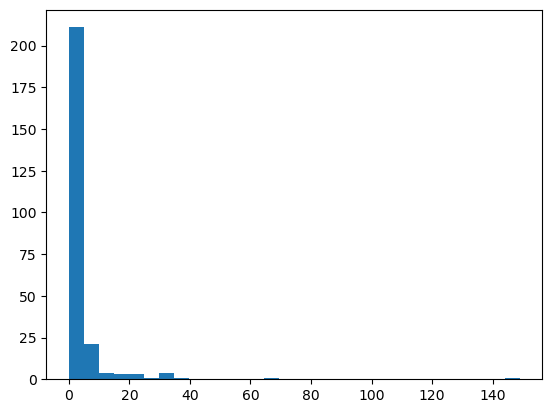

In [4]:
plt.hist(df.FISH_COUNT,30)

In [5]:
#Create the training and test data sets. Note that for now, we are not doing a stratified random split:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=200
Testing data set length=50


We define the Poisson equation

In [6]:
expr = 'FISH_COUNT ~ LIVE_BAIT  + CAMPER + CHILDREN + PERSONS'

In [7]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

We want to now fit Zero Inflated model which is a combination of Logit and Poisson. We have to define exog_infl vector which lists the covariates which help in classifying campers who do not go for fishing vs others. Currently I using same covariates (X_train) for classification. But we can define any vactor for exog_infl.

In [8]:
#The ZeroInflatedPoisson model class will internally use a LogisticRegression model to 
#estimate the parameter ϕ. Hence we set the model parameter inflation to ’logit’
zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 3.119968
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44


C:\Users\rtelang\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
print(zip_training_results.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              FISH_COUNT   No. Observations:                  200
Model:             ZeroInflatedPoisson   Df Residuals:                      195
Method:                            MLE   Df Model:                            4
Date:                 Sun, 18 Feb 2024   Pseudo R-squ.:                  0.3578
Time:                         22:21:17   Log-Likelihood:                -623.99
converged:                        True   LL-Null:                       -971.71
Covariance Type:             nonrobust   LLR p-value:                3.413e-149
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept     1.3444      0.931      1.443      0.149      -0.481       3.170
inflate_LIVE_BAIT     0.0993      0.789      0.126      0.900      -1.448       1.646
inflate_CAMPER  

In [10]:
zip_predictions = zip_training_results.predict(X_test,exog_infl=X_test, which = 'mean')
predicted_counts=np.round(zip_predictions)
actual_counts = y_test['FISH_COUNT']
print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))

ZIP RMSE=28.722813232690143


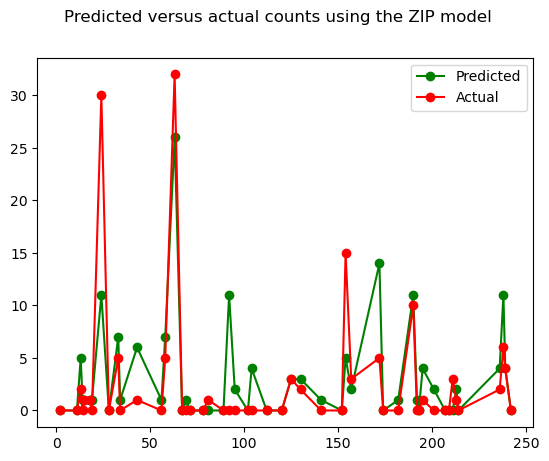

In [11]:
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the ZIP model')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

here I classify based on count of fish caught

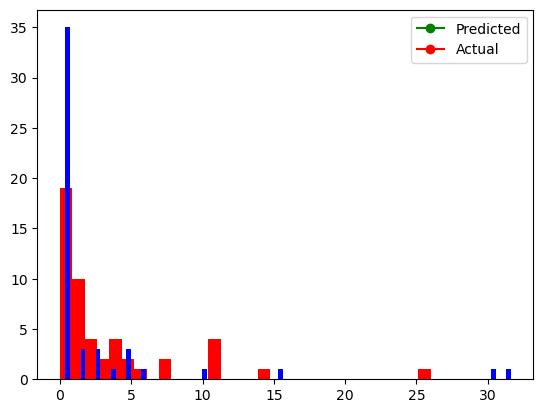

In [12]:
plt.hist(predicted_counts, bins=30,color='red',label='Predicted')
plt.hist(actual_counts, 30,color='blue',rwidth=0.3,label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

We can now fit negative Binomial model

In [13]:
NBD_results = sm.NegativeBinomial(endog=y_train, exog=X_train).fit()

Optimization terminated successfully.
         Current function value: 1.620155
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


In [14]:
NBD_results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  202
Model:               NegativeBinomial   Df Residuals:                      197
Method:                           MLE   Df Model:                            4
Date:                Wed, 04 Oct 2023   Pseudo R-squ.:                  0.1344
Time:                        09:17:03   Log-Likelihood:                -327.27
converged:                       True   LL-Null:                       -378.11
Covariance Type:            nonrobust   LLR p-value:                 4.331e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9503      0.545     -5.417      0.000      -4.018      -1.883
LIVE_BAIT      1.4455      0.456      3.170      0.002       0.552       2.339
CAMPER         0.5859      0.264      2.217      0.027       0.068       1.104
CHILDREN      -1.8853      0.228     -8.284      0.000      -2.331      -1.439
PERSONS        1.1179      0.137      8.154      0.000       0.849       1.387
alpha          2.1916      0.378      5.794      0.000       1.450       2.933
==============================================================================
"""

In [15]:
nb2_predictions = NBD_results.predict(X_test)


(array([25., 11.,  2.,  0.,  2.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ 0.        ,  0.73333333,  1.46666667,  2.2       ,  2.93333333,
         3.66666667,  4.4       ,  5.13333333,  5.86666667,  6.6       ,
         7.33333333,  8.06666667,  8.8       ,  9.53333333, 10.26666667,
        11.        , 11.73333333, 12.46666667, 13.2       , 13.93333333,
        14.66666667, 15.4       , 16.13333333, 16.86666667, 17.6       ,
        18.33333333, 19.06666667, 19.8       , 20.53333333, 21.26666667,
        22.        ]),
 <BarContainer object of 30 artists>)

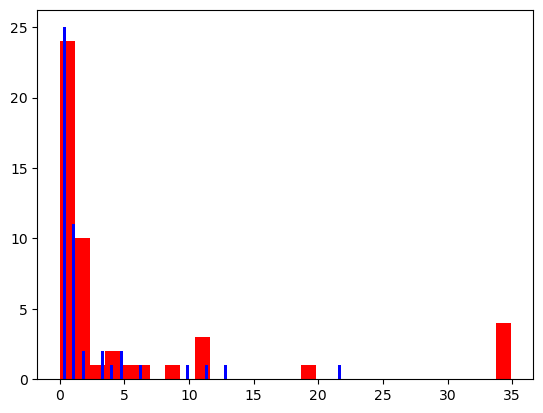

In [16]:
plt.hist(nb2_predictions,30,color='red')
plt.hist(actual_counts, 30,color='blue',rwidth=0.3)

In [17]:
zipNBD_training_results = sm.ZeroInflatedNegativeBinomialP(endog=y_train, exog=X_train, exog_infl=X_train, inflation='logit').fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 1.577693
         Iterations: 86
         Function evaluations: 91
         Gradient evaluations: 91


In [18]:
zipNBD_training_results.summary()

C:\Users\rtelang\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\rtelang\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                        FISH_COUNT   No. Observations:                  202
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      197
Method:                                      MLE   Df Model:                            4
Date:                           Wed, 04 Oct 2023   Pseudo R-squ.:                  0.1571
Time:                                   09:17:14   Log-Likelihood:                -318.69
converged:                                  True   LL-Null:                       -378.11
Covariance Type:                       nonrobust   LLR p-value:                 9.508e-25
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_Intercept    -1.1498      2.859     -0.402      0.688      -6.753       4.453
inflate_LIVE_BAIT     1.4335      2.316      0.619      0.536      -3.106       5.973
inflate_CAMPER       -2.0634      1.065     -1.938      0.053      -4.150       0.023
inflate_CHILDREN      2.7530      0.767      3.589      0.000       1.249       4.257
inflate_PERSONS      -0.7902      0.473     -1.672      0.095      -1.717       0.136
Intercept            -2.6646      0.579     -4.601      0.000      -3.800      -1.529
LIVE_BAIT             1.6374      0.465      3.524      0.000       0.727       2.548
CAMPER                0.2587      0.297      0.870      0.384      -0.324       0.841
CHILDREN             -1.1805      0.305     -3.871      0.000      -1.778      -0.583
PERSONS               1.0243      0.143      7.143      0.000       0.743       1.305
alpha                 1.4399      0.350      4.118      0.000       0.755       2.125
=====================================================================================
"""

In [19]:
nbdzip_predictions = zipNBD_training_results.predict(exog=X_test,exog_infl=X_test,which='mean')

In [20]:
predicted_nbdzip_counts=np.round(nbdzip_predictions)


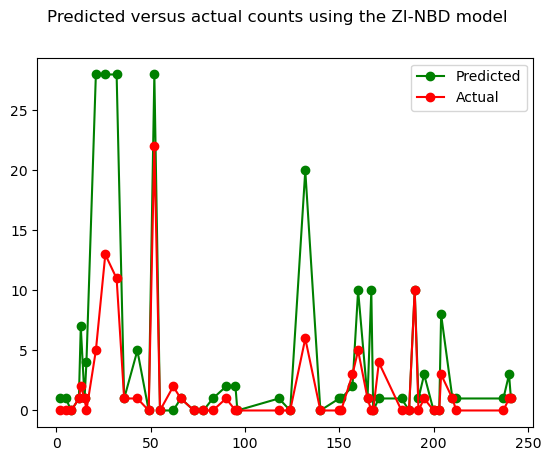

In [21]:
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the ZI-NBD model')
predicted, = plt.plot(X_test.index, predicted_nbdzip_counts, 'go-', label='Predicted')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()